## Image classification (single label)

Each image has one given label ("effusion", "normal")

Documentation:

Creating a dataset, training:
https://towardsdatascience.com/image-classification-using-fastai-v2-on-colab-33f3ebe9b5a3

Training, prediction + interpretation:
https://docs.fast.ai/tutorial.medical_imaging.html

In [1]:
# When I want to close any Google Colab project, before 
# I have to finish all the opened sessions 
# (go to Entorno de ejecucion > Gestionar sesiones)
# After finishing all the sesions I've to
# select None as execution environment 

# The next lines should be uncommented only when loading a new execution environment (GPU/TPU)
# NOTE: uncomment next lines when running this notebook on Drive
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0 = id of the gpu
# To know which id have to be set on the previous line, on Windows 10 run "nvidia-smi" on CMD to check all the installed GPUs data, like
# the id, driver version and CUDA version 

# Check if your GPU driver and CUDA is enabled and is accessible by PyTorch
# TO USE CUDA SELECT A GPU ON THE EXECUTION ENVIRONMENT, NOT A TPU
import torch; print(torch.version.cuda) # the CUDA version must be printed
print(torch.cuda.is_available()) # True must be printed (if False press on the Restart button at the top of the notebook)
print(torch.cuda.current_device()) # the id of the GPU must be printed

11.3
True
0


In [4]:
# Uncomment next line if "from fastai.vision.all import *" returns error
#!pip install fastai --upgrade # NOTE: uncomment on Drive 

from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import accuracy
#from torch.nn import L1Loss
from skimage.util import montage
import numpy as np

In [5]:
# Get the path of the dataset  

ds_path = '../Datasets/RepoGithub_ref/grids_ds/train_val/' 

# dataset source - https://www.kaggle.com/epreis/rxtorax 

## Getting and converting the data

In [6]:
# Documentation for this cell 
# -> (DataBlock creation) https://docs.fast.ai/tutorial.datablock.html#Bounding-boxes
# -> (Split train/val data) https://docs.fast.ai/data.transforms.html#FuncSplitter 

def grand_parent_label(item):
    "Label `item` with it's grand parent folder name."
    return Path(item).parent.parent.name

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # CategoryBlock = label
    get_items=get_image_files,
    get_y= grand_parent_label, # grand_parent_label = the grand parent folder names of an images is it's label (normal/effusion)
    splitter= FuncSplitter(lambda img: Path(img).parent.parent.parent.name == 'valid'), # split items by result of func (True for validation, False for training set). 
    batch_tfms= [*aug_transforms(do_flip=False, size=(120,160)), Normalize.from_stats(*imagenet_stats)] 
)

# On FuncSplitter, If an image path is '[...] train_val/train/normal/normal0.png' 'normal0.png' gets added to the training set. 
# And if an image path is '[...] train_val/valid/normal/normal1.png 'normal1' gets added to the validation set. 

In [7]:
path_dl = Path(ds_path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#4) [Path('models'),Path('train'),Path('trained_effusion_classif_export.pkl'),Path('valid')]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\marcp\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\_tensor.py:1142: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  ret = func(*args, **kwargs)


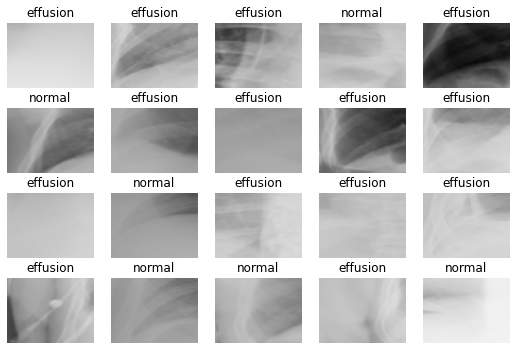

In [8]:
# Load the data and show a batch # NOTE: research to explain more properly what the 2 next lines do 

dls = data.dataloaders(path_dl, path=path_dl, bs = 64) # bs: how many samples per batch to load 
# If your GPU doesn't have enough memory and you can't run the whole notebook, 
# reduce the bs parameter value to, for example, 16 or 8
# and press the Restart button at the top of the notebook to empty the used memory

dls.show_batch(max_n=20, figsize=(9,6)) # NOTE: what do the values of figsize represent?
# NOTE: The batch shown contains validation and training images?

In [9]:
# Checks the labels using vocab

dls.vocab

['effusion', 'normal']

## Train model



In [10]:
# Create a CNN learner using resnet50
# Which architecture should we use?: 
# Check: https://theaisummer.com/cnn-architectures/
# According to the previous doc, a priori resnet50 presents higher accuracy than e.g. resnet34, resnet18
# resnet50 has more parameters than resnet34 and restnet18
# More parameters needs more computing power and memory during training


# A Leaner is a trainer for model using data (dls) to minimize the loss
learn = cnn_learner(dls, resnet50, metrics=accuracy)


#learn.load('effusion_classification_stage-1')
# If we have a saved model with the right accuracy, we can load it without having to train it again
# We can load a saved model by adding "learn.load(name of the model)" after "learn" has been initialized
# Then we have to comment all the following functions until the Data Augmentation cell
# because they had been previously executed on the loaded model

In [11]:
learn.model

# There are layer groups in any model architecture
# The initial layers are mostly used for understanding low-level features like 
# curves, lines, shapes, patterns. 
# When we use pre-trained models they are trained for identifying these features 
# on a large dataset of images like Imagenet(1000 categories).

# The later layers are mainly for capturing high-level features on current dataset like pets.
# These are fully connected layers which identify features like the shape of a dog or cat in its entirety.
# These layers hold composite or aggregated information from previous layers related to our current data.
# We improve information captured by these layers by training the model and optimizing loss based on target labels.( (i.e. requires_grad=True ).)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### 1st training (earlier layers freezed)

In [12]:
# Freeze all layers except the last one 
learn.freeze_to(-1)

# NOTE: By default when you load the model from fastai library, 
# it will have all the layers frozen i.e pre-trained weights, 
# say resnet (or any other preatrained model) won’t get modified
# If you print "learn.summary()" you will find most of the starting layers 
# are set to trainable=False.( (i.e. requires_grad=False ).)
# So you don’t need to explicitly use "learn.freeze()"
# you can directly start training using "learn.fit_one_cycle()"


# Freezing basically prevents well-trained weights from being modified, 
# that’s called transfer learning. (i.e. requires_grad=False ).
# Gradients are not calculated for those layers.


# Check which layers are frozen by default with "learn.summary"
learn.summary()

Sequential (Input shape: 64 x 3 x 120 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 60 x 80   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 30 x 40   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 30 x 40  
Conv2d                                    16384      False     
BatchNorm2d                        

SuggestedLRs(valley=0.00013182566908653826)


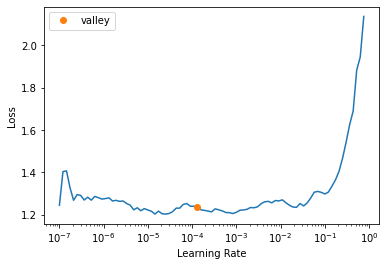

In [13]:
# Show a suitable learning rate

lr_valley = learn.lr_find()
print(lr_valley)
# Launch a mock training to find a good learning rate, return lr_min, lr_steep if suggestions is True

# NOTE
# Learning too slowly: If the learning rate is too small it will take 
# a really long time to train your model. 

# Learning too quickly: If the learning rate is too large, 
# the steps it takes will be so big it overshoots what is an optimal model. 
# Quite simply your accuracy will just bounce all over the place rather than 
# steadily improving.

In [14]:
# Train only the last layer group i.e fully connected layer using fit_one_cycle

learn.fit_one_cycle(100, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.274545,1.043507,0.450000,00:47
1,1.190511,0.834081,0.572222,00:17
2,1.168081,0.771013,0.622222,00:40
3,1.172638,0.745283,0.622222,00:41
4,1.109913,0.716724,0.644444,00:41
5,1.098355,0.713845,0.644444,00:41
6,1.069549,0.721412,0.633333,00:41
7,1.066430,0.688174,0.650000,00:41
8,1.025391,0.719163,0.638889,00:41
9,0.990669,0.705535,0.677778,00:41


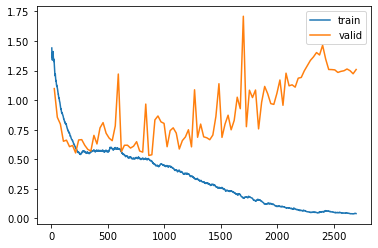

In [ ]:
learn.recorder.plot_loss() 

### 2nd training (unfreeze the network)

In [ ]:
# Now we can unfreeze the network and train the whole network

learn.unfreeze()

# All of the layers are trainable =True now.
# It sets every layer group to trainable (i.e. requires_grad=True ).
# All weights from frozen layers of the model now can get updated from their pre-trained state according to loss function. 
# You can change this behavior by instead using freeze_to() method which allows you to keep some layers frozen.


SuggestedLRs(valley=3.0199516913853586e-05)

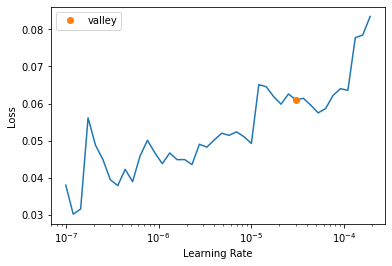

In [ ]:
learn.lr_find()

In [ ]:
# Train by using discriminative learning rates
# Maintain a low learning rate for initial layers as they need lesser tuning 
# and gradually increase learning rate for later layers which need higher 
# tuning especially fully connected ones.

learn.fit_one_cycle(200, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.042690,1.226686,0.730000,00:13
1,0.045781,1.253471,0.730000,00:13
2,0.045349,1.252576,0.725000,00:13
3,0.049295,1.263362,0.730000,00:13
4,0.043534,1.240904,0.730000,00:13
5,0.045682,1.258091,0.725000,00:13
6,0.041856,1.272059,0.715000,00:13
7,0.041745,1.268575,0.725000,00:13
8,0.041485,1.233804,0.725000,00:13
9,0.041986,1.269146,0.720000,00:13


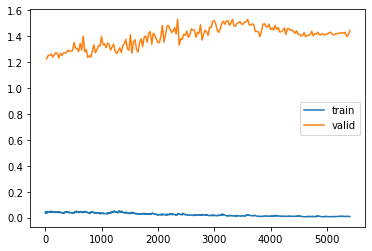

In [ ]:
# Plot losses 

# If the model has been trained correctly train loss must be lower than validation loss.

learn.recorder.plot_loss() 
# X axis refers to the number of epochs 
# Y axis refers to the losses 

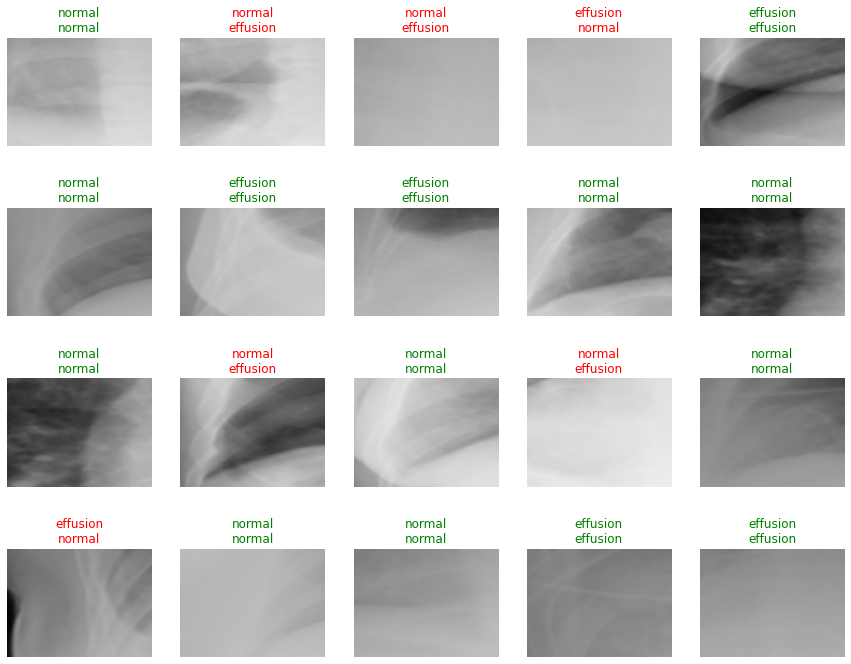

In [ ]:
learn.show_results(max_n=20)

In [ ]:
# Save the model parameters (from layer 1 to layer n all the weights are saved.)
learn.save('effusion_classification_stage-1')
# The file gets stored at the models folder that is a new folder created inside the dataset folder 

# Architecture is not saved so you have to define the same 
# architecture in order to use these weights again.(freeze/ unfreeze details are not saved.)

# We can load the model parameters after "learn" is initialized by calling to "learn.load(roi_detector_stage-1)"



Path('models/effusion_classification_stage-1.pth')

In [ ]:
# Use export function to save the Learner in dataset path/fname, using pickle_protocol. 
# Note that serialization in Python saves the names of functions, not the code itself. 
# Therefore, any custom code you have for models, data transformation, loss function etc... 
# should be put in a module that you will import in your training environment before exporting, 
# and in your deployment environment before loading it.
learn.export('trained_effusion_classif_export.pkl') # NOTE: what type of program can open a pkl file?
# The file gets stored at the dataset folder 

## Inference 

In [ ]:
testDsPath = "../Datasets/RepoGithub_ref/grids_ds/test/"

effusionTestPath = testDsPath + "effusion"
normalTestPath = testDsPath + "normal"

# Recursively get the list of normal and effusion test images paths 
effusionTestImgsPaths =get_image_files(effusionTestPath)
normalTestImgsPaths = get_image_files(normalTestPath)

'''
ALTERNATIVE TO RECURSIVELY GET IMAGES INSIDE SUBFOLDERS 
files = glob.glob(my_path + '/**/*.png', recursive=True)

# my_path/     the dir
# **/       every file and dir under my_path
# *.png     every file that ends with '.png'
'''
# ---------------------------------------
# APPLY INFERENCE 

# 1st OPTION. PREDICTION ON SINGLE IMAGES - NOTE: don't know how to show predictions results
# 
# When predicting on an image learn.predict returns a tuple (class, class tensor and [probabilities of each class]).
# In this dataset there are only 2 classes "normal" and "effusion" hence the reason why each probability has 2 values,
# the first value is the probability whether the image belongs to class 0 or "effusion" and the second value is the probability 
# whether the image belongs to class 1 or "normal"
#  

for effImgPath in effusionTestImgsPaths:
    predLabel = learn.predict(effImgPath)[0] # NOTE: Try to make blank output disappear
    imgName = str(effImgPath).split('\\')[-1]
    imgParentName = str(effImgPath).split('\\')[-2]
    imgSubPath = os.path.join(imgParentName, imgName)
    print("Effusion test image '{}' predicted label is: {}".format(imgSubPath, predLabel))
    

for normalImgPath in normalTestImgsPaths:
    predLabel = learn.predict(normalImgPath)[0] # NOTE: Try to make blank output disappear
    imgName = str(normalImgPath).split('\\')[-1]
    imgParentName = str(normalImgPath).split('\\')[-2]
    imgSubPath = os.path.join(imgParentName, imgName)
    print("Normal test image '{}' predicted label is: {}".format(imgSubPath, predLabel))

# The printed results show that 13/16 images were predicted right -> accuracy 81%
# TODO: the predictions results and the accuracy statistics must be stored in an Excel for a better analysis 

# 2nd option. BATCH PREDICTION (NOT WORKING - ERROR on learn.show_results: AssertionError: Match length mismatch)
'''
testEffusion_dl = learn.dls.test_dl(effusionTestImgsPaths)
preds, _ = learn.get_preds(dl=testEffusion_dl)
# Show the predictions results on the effusion test images
learn.show_results(dl=testEffusion_dl, max_n=8)


testNormal_dl = learn.dls.test_dl(normalTestImgsPaths)
preds, _ = learn.get_preds(dl=testNormal_dl)
# Show the predictions results on the normal test images
learn.show_results(dl=testNormal_dl, max_n=8)
'''



Effusion test image 'effusion400\D3.png' predicted label is: effusion


Effusion test image 'effusion400\E3_flipped.png' predicted label is: effusion


Effusion test image 'effusion401\D3.png' predicted label is: effusion


Effusion test image 'effusion401\E3_flipped.png' predicted label is: effusion


Effusion test image 'effusion402\D3.png' predicted label is: effusion


Effusion test image 'effusion402\E3_flipped.png' predicted label is: normal


Effusion test image 'effusion403\D3.png' predicted label is: effusion


Effusion test image 'effusion403\E3_flipped.png' predicted label is: effusion


Normal test image 'normal400\D3.png' predicted label is: effusion


Normal test image 'normal400\E3_flipped.png' predicted label is: effusion


Normal test image 'normal401\D3.png' predicted label is: normal


Normal test image 'normal401\E3_flipped.png' predicted label is: normal


Normal test image 'normal402\D3.png' predicted label is: normal


Normal test image 'normal402\E3_flipped.png' predicted label is: normal


Normal test image 'normal403\D3.png' predicted label is: normal


Normal test image 'normal403\E3_flipped.png' predicted label is: normal


'\ntestEffusion_dl = learn.dls.test_dl(effusionTestImgsPaths)\npreds, _ = learn.get_preds(dl=testEffusion_dl)\nprint(preds)\n# Show the predictions results based on the effusion test images\nlearn.show_results(dl=testEffusion_dl, max_n=8)\n\n\ntestNormal_dl = learn.dls.test_dl(normalTestImgsPaths)\npreds, _ = learn.get_preds(dl=testNormal_dl)\n# Show the predictions results based on the normal test images\nlearn.show_results(dl=testNormal_dl, max_n=8)\n'

## Interpretation

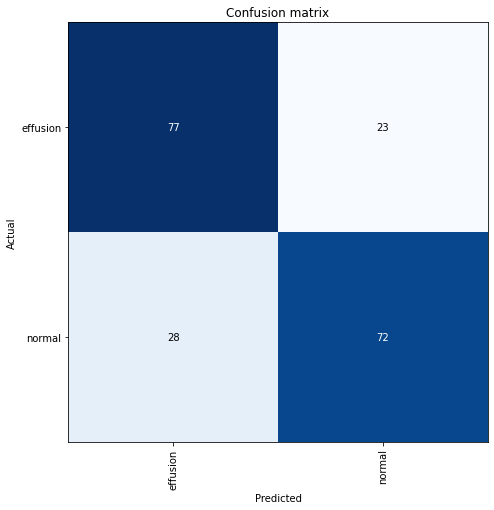

In [ ]:
# Plot a confusion matrix 

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
# Get the sensitivity (Sensitivity = True Positive/(True Positive + False Negative))

upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1] # tn = True Negative; fp = False Positive 
fn, tp = low[0], low[1] # fn = False Negative; tp = True Positive

sensitivity = tp/(tp + fn)
print("Sensitivity: ", sensitivity)
# For example, if sensitivity is equal to 40% it means the model is only capable of correctly detecting 40% True Positives
# (i.e. who are labeled as Normal) but will miss 60% of False Negatives (patients that actually have Effusion but were told they did not! Not a good situation to be in).

Sensitivity:  0.72


In [ ]:
# Compute specificity

specificity = tn/(fp + tn)
print("Specificity: ", specificity)

# For example, if the model has a specificity of 63% and hence can correctly detect 63% of the time 
# that a patient does not have Effusion but will incorrectly classify that 37% of the patients have Effusion (False Postive) but actually do not.

Specificity:  0.77


In [ ]:
# Positive Predictive Value (PPV), between 0 and 1

ppv = tp/(tp+fp)
print("Positive Predictive Value: ", ppv)
# If ppv is low it means the model doesn't perform well in correctly predicting patients with Effusion
# If ppv is high it means the model predicts well the patients with Effusion

Positive Predictive Value:  0.7578947368421053


In [ ]:
# Negative Predictive Value (NPV)

npv = tn/(tn+fn)
print("Negative Predictive Value: ", npv)

# If npv is low it means the model doesn't perform well in correctly predicting patients which don't have Effusion
# If npv is high it means the model predicts well the patients with Effusion

Negative Predictive Value:  0.7333333333333333
